**RFM Segmentation** is a great method to divide
Customers into equal groups depending on three criteria:

**Recency**:- How much time has elapsed since a customer’s last activity or transaction with the company?

**Frequency**:- How often has a customer transacted with the company during a particular period of time?

**Monetary**:- How much a customer has spent with the brand during a particular period of time?


In [68]:
# Import libraries
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
!pip install squarify
import squarify
# Read dataset
df = pd.read_csv('data.csv', encoding = "ISO-8859-1")
# Convert InvoiceDate from object to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [69]:
print('First five rows in the dataset:-')
print(df.head())
print('Last five rows in the dataset:-')
print(df.tail())
print(df.info())
print(df.describe())
print('There are {:,} rows and {:,} columns in the dataset.'
      .format(df.shape[0], df.shape[1]))
print('-----------------------------------------------------')
print('{:,} transactions don\'t have a customer id'
      .format(df[df.CustomerID.isnull()].shape[0]))
print('-----------------------------------------------------')
print('Transactions has been started from {} to {}'.format(df['InvoiceDate'].min(),
                                    df['InvoiceDate'].max()))

First five rows in the dataset:-
  InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]
Last five rows in the dataset:-
       InvoiceNo StockCode  ... CustomerID  Country
541904    581587     22613  ...    12680.0   France
541905    581587     22899  ...    12680.0   France
541906    581587     23254  ...    12680.0   France
541907    581587     23255  ...    12680.0   France
541908    581587     22138  ...    12680.0   France

[5 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null 

In [70]:
# --Group data by customerID--
# Create TotalSum column for online dataset
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
# Create snapshot date
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)
# Grouping by CustomerID
data_process = df.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalSum': 'sum'})
# Rename the columns 
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

2011-12-10 12:50:00


In [71]:
# Print top 5 rows and shape of dataframe
print(data_process.head())
print('{:,} rows; {:,} columns'
      .format(data_process.shape[0], data_process.shape[1]))

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          2           0.00
12347.0           2        182        4310.00
12348.0          75         31        1797.24
12349.0          19         73        1757.55
12350.0         310         17         334.40
4,372 rows; 3 columns


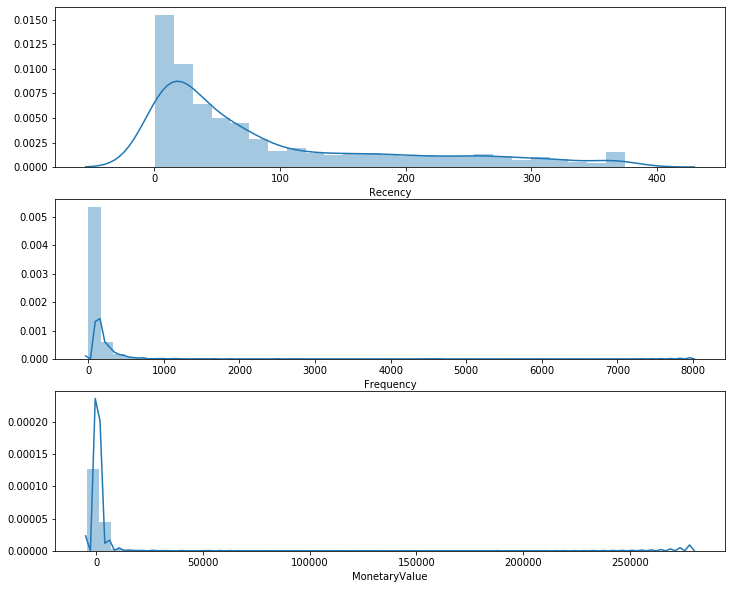

In [72]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
# Show the plot
plt.show()

In [73]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,R,F
CustomerID,,,,,
12346.0,326,2,0.00,1,1
12347.0,2,182,4310.00,4,4
12348.0,75,31,1797.24,2,2
12349.0,19,73,1757.55,3,3
12350.0,310,17,334.40,1,1


In [0]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [75]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,111
12347.0,2,182,4310.00,4,4,4,444
12348.0,75,31,1797.24,2,2,4,224
12349.0,19,73,1757.55,3,3,4,334
12350.0,310,17,334.40,1,1,2,112


In [76]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

62


In [77]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

CustomerID
12346.0     3.0
12347.0    12.0
12348.0     8.0
12349.0    10.0
12350.0     4.0
Name: RFM_Score, dtype: float64


In [78]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3.0,Require Activation
12347.0,2,182,4310.00,4,4,4,444,12.0,Can't Loose Them
12348.0,75,31,1797.24,2,2,4,224,8.0,Champions
12349.0,19,73,1757.55,3,3,4,334,10.0,Can't Loose Them
12350.0,310,17,334.40,1,1,2,112,4.0,Needs Attention


In [79]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({'Recency':{'RECENCY_MEAN': 'mean'},'Frequency': {'FRQUENCY_MEAN':'mean'},'MonetaryValue': {'MONETARY_MEAN': 'mean', 'MONETARY_COUNT': 'count'}}).round(1)
rfm_level_agg.columns = rfm_level_agg.columns.droplevel(0)
# Print the aggregated dataset
print(rfm_level_agg)

                    RECENCY_MEAN  FRQUENCY_MEAN  MONETARY_MEAN  MONETARY_COUNT
RFM_Level                                                                     
Can't Loose Them            25.2          195.1         4130.3            1690
Champions                   62.7           57.0          974.7             467
Loyal                       78.8           39.7          724.2             447
Needs Attention            174.5           13.9          227.1             391
Potential                   94.3           28.5          491.8             468
Promising                  153.0           21.2          346.8             517
Require Activation         264.8            7.8          109.1             392


/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


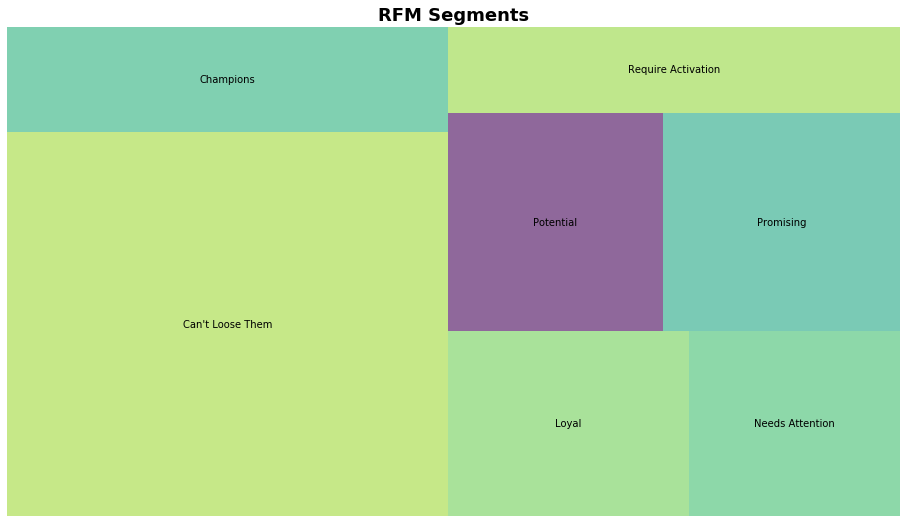

In [80]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['MONETARY_COUNT'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()
